# Stock Price Prediction using Machine Learning

In [ ]:
pip install yfinance xgboost ta scikit-learn matplotlib seaborn pandas numpy


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
print("Imported")

Imported


In [3]:
# User Input
ticker = input("Enter Stock Ticker Symbol (e.g., AAPL): ").upper()
start_date = input("Enter Start Date (YYYY-MM-DD): ")
end_date_input = input("Enter End Date (YYYY-MM-DD): ")

# Adjust end_date for yfinance (+1 day to include the actual end_date in the range)
end_date = (pd.to_datetime(end_date_input) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

Enter Stock Ticker Symbol (e.g., AAPL):  AAPL
Enter Start Date (YYYY-MM-DD):  2020-03-20
Enter End Date (YYYY-MM-DD):  2024-03-20


In [4]:
# Load data
df = yf.download(ticker, start=start_date, end=end_date)
display(df)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-03-20,55.631748,61.113867,55.330825,59.985407,401693200
2020-03-23,54.449894,55.452160,51.595990,55.350235,336752800
2020-03-24,59.912598,60.109167,56.859695,57.359613,287531200
2020-03-25,59.582554,62.671857,59.286485,60.851764,303602000
2020-03-26,62.717972,62.776212,59.786409,59.825238,252087200
...,...,...,...,...,...
2024-03-14,172.186966,173.490807,171.241434,172.097393,72913500
2024-03-15,171.808731,171.808731,169.489680,170.365549,121664700


In [5]:
df.columns = df.columns.get_level_values(0)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
print("Data flattened.")

Data flattened.


In [6]:
# Technical Indicators
df['SMA_14'] = SMAIndicator(df['Close'], window=14).sma_indicator()
df['EMA_14'] = EMAIndicator(df['Close'], window=14).ema_indicator()
df['RSI_14'] = RSIIndicator(df['Close'], window=14).rsi()
macd = MACD(close=df['Close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

# Lag features & Target
df['Lag_1'] = df['Close'].shift(1)
df['Lag_2'] = df['Close'].shift(2)
df['Lag_3'] = df['Close'].shift(3)
df['Target'] = df['Close'].shift(-1)


In [7]:
# Drop missing values
df.dropna(inplace=True)
display(df.isna().sum())

Price
Open           0
High           0
Low            0
Close          0
Volume         0
SMA_14         0
EMA_14         0
RSI_14         0
MACD           0
MACD_Signal    0
Lag_1          0
Lag_2          0
Lag_3          0
Target         0
dtype: int64

In [8]:
# Features
features = ['Open', 'High', 'Low', 'Volume', 'SMA_14', 'EMA_14',
            'RSI_14', 'MACD', 'MACD_Signal', 'Lag_1', 'Lag_2', 'Lag_3']
X = df[features]
y = df['Target']

In [9]:
#Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Train-test split
split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [11]:
# Training and fitting with XGBOOST
model_XGB = XGBRegressor(
    n_estimators=300,           
    learning_rate=0.03,         
    max_depth=5,                
    subsample=0.9,              
    colsample_bytree=0.8,       
    gamma=0,                   
    reg_alpha=0.5,              
    reg_lambda=1,               
    random_state=42,
    objective='reg:squarederror'
)
model_XGB.fit(X_train, y_train)

# Prediction
y_pred_XGB = model_XGB.predict(X_test)

In [12]:
# Evaluation function
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    accuracy = np.mean(np.abs((y_test - y_pred) / y_test) < 0.02) * 100
    print(f"\nEvaluation metrics for {name}:")
    print(f"  Mean Squared Error : {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  R2 Score           : {r2:.4f}")
    print(f"  Accuracy (±2%)     : {accuracy:.2f}%")
    return y_pred

In [13]:
#evaluating xgboost model
display(evaluate_model("XGBoost", model_XGB, X_test, y_test))


Evaluation metrics for XGBoost:
  Mean Squared Error : 119.0339
  Mean Absolute Error: 9.5149
  R2 Score           : -0.9792
  Accuracy (±2%)     : 15.90%


array([177.08551, 176.96117, 176.96735, 177.12505, 177.14725, 176.8274 ,
       176.3269 , 176.15714, 176.49661, 176.79416, 176.12299, 176.40265,
       176.49661, 176.40536, 176.64868, 175.71301, 175.8914 , 175.90077,
       175.8105 , 175.73456, 174.55058, 177.24638, 176.50092, 176.6325 ,
       177.3791 , 177.18582, 177.01276, 177.43933, 176.98656, 176.63272,
       176.79294, 177.25777, 176.74266, 177.37088, 177.0317 , 176.92163,
       175.1634 , 173.47292, 171.97836, 172.18399, 172.6251 , 172.62477,
       172.53505, 172.97595, 172.10968, 173.36844, 173.30887, 169.42575,
       169.7261 , 170.77205, 171.57962, 173.08298, 171.92093, 172.90982,
       172.76714, 173.71594, 175.42923, 175.75119, 175.2333 , 175.38866,
       172.64333, 170.42775, 171.85954, 171.55315, 169.92975, 170.40321,
       170.73518, 169.69482, 171.83214, 172.2487 , 170.55786, 170.45943,
       170.18355, 170.31207, 167.14769, 166.93594, 164.66423, 167.95981,
       169.01689, 167.6518 , 168.41505, 168.9044 , 

In [14]:
#xgboost results
results = pd.DataFrame({
    'Date':y_test.index,
    'Actual': y_test.values,
    'Predicted': y_pred_XGB
})
results.set_index('Date', inplace=True)

#displaying first 5 predictions
print("\nActual vs Predicted Closing Prices(XGBoost Model):\n")
display(results.head())


Actual vs Predicted Closing Prices(XGBoost Model):



,Actual,Predicted
Date,,
2023-06-09,182.206726,177.085510
2023-06-12,181.730850,176.961166
2023-06-13,182.365326,176.967346
2023-06-14,184.407578,177.125046
2023-06-15,183.326981,177.147247


In [15]:
# Training and fitting with Gradient Boosting Regressor
model_GB = GradientBoostingRegressor(
    n_estimators=250,
    learning_rate=0.05,         
    max_depth=4,                
    subsample=0.8,              
    min_samples_split=3,
    min_samples_leaf=2,
    random_state=42
)
model_GB.fit(X_train, y_train)

#prediction
y_pred_GB = model_GB.predict(X_test)

In [16]:
#evaluating Gradient boost model
evaluate_model("Gradient Boosting", model_GB, X_test, y_test)


Evaluation metrics for Gradient Boosting:
  Mean Squared Error : 92.4200
  Mean Absolute Error: 7.9282
  R2 Score           : -0.5367
  Accuracy (±2%)     : 27.18%


array([177.84601478, 177.92130263, 177.42768926, 177.93462018,
       177.55382332, 177.31896027, 177.19187295, 176.88777741,
       177.22140228, 177.26310563, 176.91220193, 177.19187295,
       177.22140228, 177.18079801, 177.8586827 , 177.55495654,
       177.20065138, 177.12336428, 176.63470674, 176.51146517,
       175.51076427, 177.25756311, 177.35513463, 177.78863338,
       177.9431211 , 177.90417235, 177.83663073, 178.22465563,
       177.0731305 , 177.21877009, 177.74734271, 177.99478956,
       177.00386499, 177.93822124, 178.12187427, 177.71658373,
       176.6953785 , 175.56062434, 173.13903455, 175.22840849,
       174.05393039, 176.37616972, 176.53419775, 177.67479316,
       177.01551396, 176.34773748, 177.8831951 , 174.06389046,
       173.36440616, 171.62823861, 173.75198685, 175.89122596,
       174.28290745, 177.35829549, 176.89887958, 175.83844744,
       177.94145938, 177.90667263, 177.78840462, 177.67782014,
       175.25831842, 171.75459703, 174.20633934, 175.08

In [17]:
#Gradiant boosting results
results_df = pd.DataFrame({
    'Date': y_test.index,
    'Actual Close': y_test.values,
    'Predicted Close': y_pred_GB
})
results_df.set_index('Date', inplace=True)

# Display first 5 predictions
print("\nActual vs Predicted Closing Prices(Gradiant Boosting model):\n")
display(results_df.head())


Actual vs Predicted Closing Prices(Gradiant Boosting model):



,Actual Close,Predicted Close
Date,,
2023-06-09,182.206726,177.846015
2023-06-12,181.730850,177.921303
2023-06-13,182.365326,177.427689
2023-06-14,184.407578,177.934620
2023-06-15,183.326981,177.553823


In [18]:
#training and fitting with Linear Regreesion
model_LR = LinearRegression(
    fit_intercept=True,   
    copy_X=True,          
    n_jobs=-1             
)
model_LR.fit(X_train, y_train)

#prediction
y_pred_LR = model_LR.predict(X_test)

In [19]:
#evaluating Linear regression
evaluate_model("Linear Regression", model_LR, X_test, y_test)


Evaluation metrics for Linear Regression:
  Mean Squared Error : 5.2803
  Mean Absolute Error: 1.7281
  R2 Score           : 0.9122
  Accuracy (±2%)     : 88.72%


array([180.20055353, 182.27255832, 182.38714532, 182.02675601,
       184.76377781, 183.55728083, 184.57952869, 181.99696004,
       185.51950969, 185.69090676, 184.58907887, 186.56561112,
       188.04076152, 188.68540661, 192.30911432, 190.22288381,
       190.08784758, 189.82353727, 189.80377499, 186.7270769 ,
       185.79416225, 188.74854293, 189.26809353, 189.25473126,
       192.31915578, 191.84405656, 194.51740463, 191.4005012 ,
       190.15662205, 191.68136482, 192.57840415, 193.61928028,
       191.42090358, 194.33476886, 194.5512685 , 194.24047653,
       190.24167604, 190.00321293, 181.94922704, 177.3864641 ,
       178.00965531, 176.41278295, 177.0752989 , 176.34215432,
       177.34078971, 175.62822201, 175.52161812, 171.82857137,
       172.99252511, 173.6054205 , 175.6635622 , 179.52189483,
       174.41970042, 176.32068244, 178.07639292, 182.56562963,
       185.96706933, 187.13940761, 187.54230954, 188.14327466,
       180.62917003, 176.91911181, 179.23304819, 178.22

In [20]:
# Create DataFrame with predictions and actual values
results = pd.DataFrame({
    'Date': y_test.index,
    'Actual_Close': y_test.values,
    'Predicted_Close': y_pred_LR
})
results.set_index('Date', inplace=True)

# Displaying first 5 predictions
print("\nActual vs Predicted Closing Prices(Linear Regression):")
display(results.head())


Actual vs Predicted Closing Prices(Linear Regression):


,Actual_Close,Predicted_Close
Date,,
2023-06-09,182.206726,180.200554
2023-06-12,181.730850,182.272558
2023-06-13,182.365326,182.387145
2023-06-14,184.407578,182.026756
2023-06-15,183.326981,184.763778


In [21]:
#Traing and fitting with Random Forest
model_RF = RandomForestRegressor(
    n_estimators=150,
    max_depth=12,
    max_features='sqrt',         
    min_samples_split=4,
    min_samples_leaf=2,
    bootstrap=True,             
    random_state=42
)
model_RF.fit(X_train,y_train)

#prediction
y_pred_RF = model_RF.predict(X_test)

In [22]:
#evaluating Random Forest Model
evaluate_model("Random Forest", model_RF, X_test, y_test)


Evaluation metrics for Random Forest:
  Mean Squared Error : 94.0491
  Mean Absolute Error: 8.0940
  R2 Score           : -0.5637
  Accuracy (±2%)     : 26.67%


array([177.69684551, 177.5891355 , 177.57644831, 177.60912473,
       177.47209173, 177.24272346, 177.5051081 , 177.36121798,
       177.5051081 , 177.48600122, 177.28179307, 177.52908708,
       177.48600122, 177.48600122, 177.12988969, 177.35274839,
       177.2806136 , 177.20636502, 176.91799129, 176.7505931 ,
       176.49965708, 177.35351359, 177.46295977, 177.41989784,
       177.76537684, 177.76537684, 177.33718368, 177.51713091,
       176.80281232, 177.36747011, 177.42908373, 177.43942747,
       177.103109  , 177.44622736, 177.53446232, 177.45763781,
       176.51750247, 175.74217153, 174.43636383, 174.3064615 ,
       174.67358511, 174.67748552, 174.81183619, 174.68438648,
       174.85902557, 174.77603418, 174.46080919, 171.9146003 ,
       170.22922217, 171.06785349, 173.00049485, 174.73450055,
       174.22356824, 174.81894369, 174.95856717, 175.67190801,
       176.42856233, 176.40278573, 176.72756613, 176.72756613,
       175.14602265, 171.6150199 , 174.86528311, 174.91

In [23]:
# Create DataFrame with predictions and actual values
results = pd.DataFrame({
    'Date': y_test.index,
    'Actual_Close': y_test.values,
    'Predicted_Close': y_pred_RF
})
results.set_index('Date', inplace=True)

# Displayinf first 5 predictions
print("\nActual vs Predicted Closing Prices(Random Forest):")
display(results.head())



Actual vs Predicted Closing Prices(Random Forest):


,Actual_Close,Predicted_Close
Date,,
2023-06-09,182.206726,177.696846
2023-06-12,181.730850,177.589135
2023-06-13,182.365326,177.576448
2023-06-14,184.407578,177.609125
2023-06-15,183.326981,177.472092


In [24]:
# Predict next day after user-selected end date
last_row = df[features].iloc[-1:]
last_row_scaled = scaler.transform(last_row)

pred_xgb = model_XGB.predict(last_row_scaled)[0]
pred_gb = model_GB.predict(last_row_scaled)[0]
pred_lr = model_LR.predict(last_row_scaled)[0]
pred_rf = model_RF.predict(last_row_scaled)[0]

In [25]:
# Find the actual next trading day after the end_date_input
def get_next_trading_day(date, ticker):
    date = pd.to_datetime(date)
    next_window = yf.download(ticker, start=date + pd.Timedelta(days=1), end=date + pd.Timedelta(days=7))
    if not next_window.empty:
        return next_window.index[0], next_window['Close'].iloc[0]
    return None, None

next_trading_day, actual_next_day_price = get_next_trading_day(end_date_input, ticker)

[*********************100%***********************]  1 of 1 completed


In [26]:
# Print predictions
print(f"\nPredicted Closing Price for {ticker} on next trading day ({next_trading_day.date() if next_trading_day else 'N/A'}):")
print(f"XGBoost          : ${pred_xgb:.2f}")
print(f"Gradient Boosting: ${pred_gb:.2f}")
print(f"Linear Regression: ${pred_lr:.2f}")
print(f"Random Forest    : ${pred_rf:.2f}")

if actual_next_day_price is not None:
    print(f"Actual Close     : ${float(actual_next_day_price):.2f}")

else:
    print("Actual closing price not available yet (maybe market holiday or future date).")


Predicted Closing Price for AAPL on next trading day (2024-03-21):
XGBoost          : $169.64
Gradient Boosting: $171.35
Linear Regression: $174.49
Random Forest    : $170.72
Actual Close     : $170.56


C:\Users\boyap_jx3oxlk\AppData\Local\Temp\ipykernel_16136\2957070675.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"Actual Close     : ${float(actual_next_day_price):.2f}")


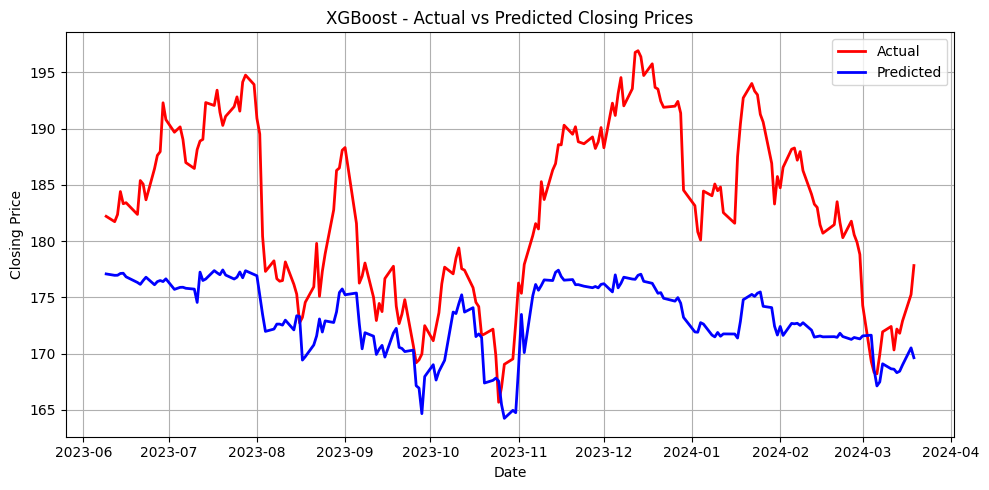

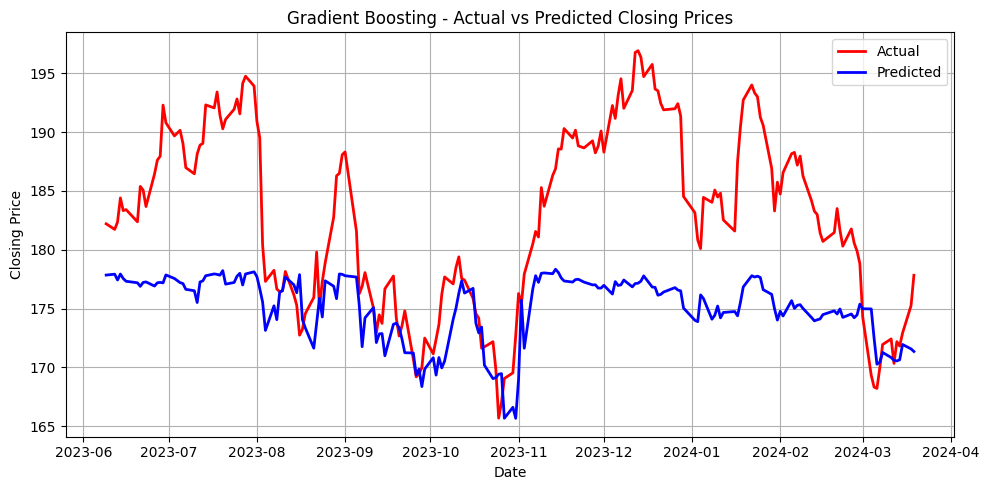

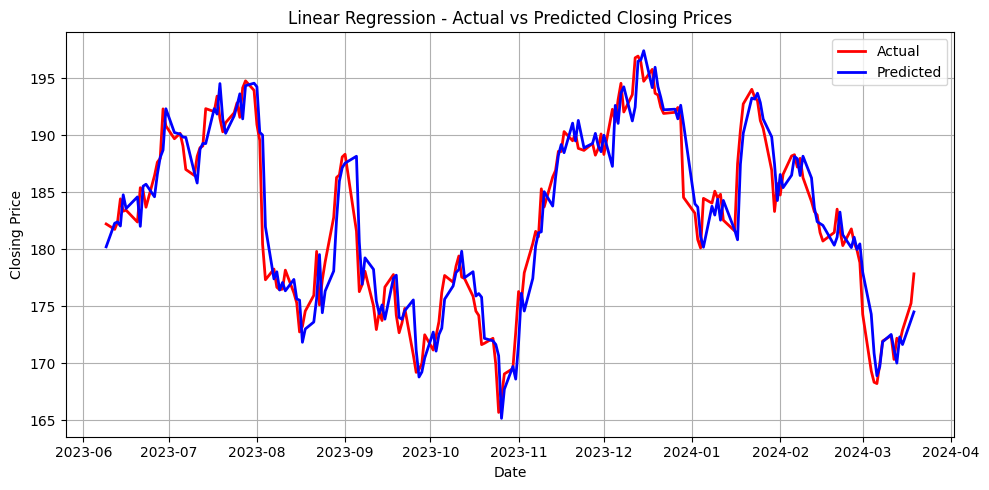

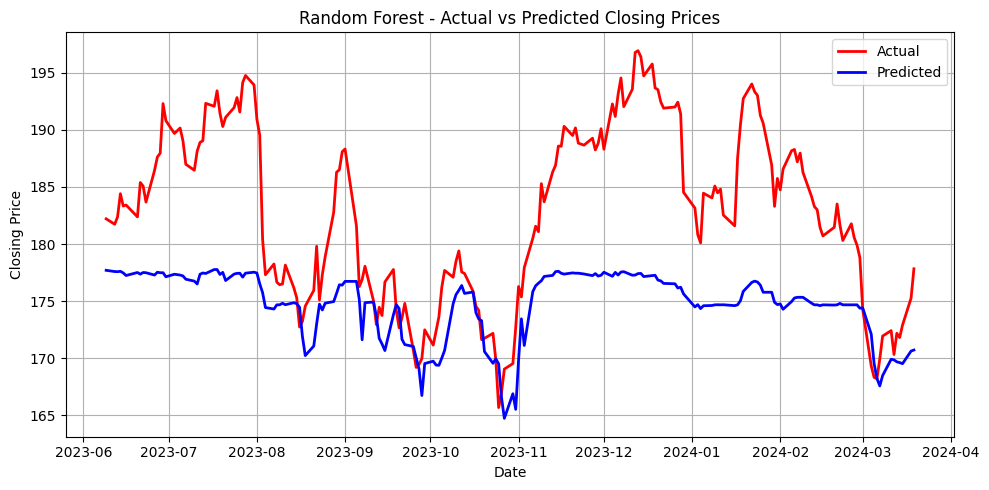

In [27]:
def plot_model_prediction(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.index, y_test.values, label='Actual', color='red', linewidth=2)
    plt.plot(y_test.index, y_pred, label='Predicted', color='blue', linewidth=2)
    plt.title(f"{model_name} - Actual vs Predicted Closing Prices")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
# Get predictions again for plotting
y_pred_xgb = model_XGB.predict(X_test)
y_pred_gb = model_GB.predict(X_test)
y_pred_lr = model_LR.predict(X_test)
y_pred_rf = model_RF.predict(X_test)

# Plot separately for each model
plot_model_prediction(y_test, y_pred_xgb, "XGBoost")
plot_model_prediction(y_test, y_pred_gb, "Gradient Boosting")
plot_model_prediction(y_test, y_pred_lr, "Linear Regression")
plot_model_prediction(y_test, y_pred_rf, "Random Forest")